In [58]:
import pandas as pd
from pathlib import Path

BASE = Path.cwd().parent
PROC = BASE / "data" / "processed"
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

fact      = pd.read_parquet(PROC / "fact_order_items.parquet")
customers = pd.read_csv(RAW / "olist_customers_dataset.csv", usecols=["customer_id","customer_unique_id"])

# Orders auf Kundenebene mit unique_id
orders_unique = (
    fact[["order_id","customer_id","order_date"]].drop_duplicates()
        .merge(customers, on="customer_id", how="left")
)

print("orders_unique:", orders_unique.shape)


orders_unique: (98199, 4)


In [59]:
orders_per_cust = orders_unique.groupby("customer_unique_id")["order_id"].nunique()


Durchschnitt Bestellungen pro Kunde: 1.034
Anteil Wiederkäufer (>1 Bestellung): 3.04 %


<Axes: title={'center': 'Verteilung Bestellungen pro Kunde'}, xlabel='order_id'>

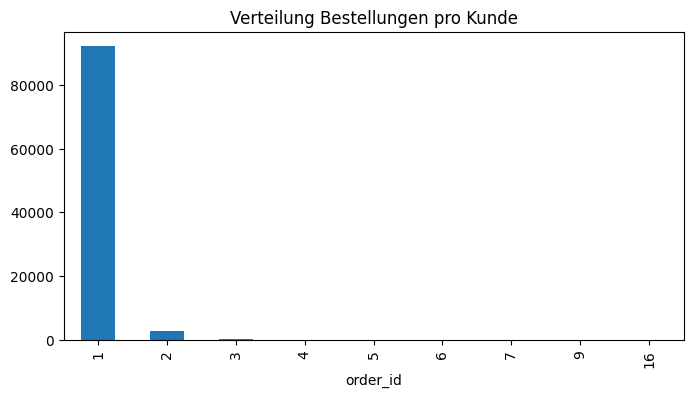

In [60]:
# Anzahl Bestellungen pro unique customer
orders_per_cust = orders_unique.groupby("customer_unique_id")["order_id"].nunique()

print("Durchschnitt Bestellungen pro Kunde:", round(orders_per_cust.mean(), 3))
print("Anteil Wiederkäufer (>1 Bestellung):", round((orders_per_cust > 1).mean() * 100, 2), "%")

# Verteilung plotten
orders_per_cust.value_counts().sort_index().plot(
    kind="bar", figsize=(8,4), title="Verteilung Bestellungen pro Kunde"
)


In [61]:
cust_dist = (
    orders_per_cust.value_counts()
    .rename_axis("anzahl_bestellungen")
    .reset_index(name="anzahl_kunden")
)
cust_dist["anteil_prozent"] = cust_dist["anzahl_kunden"] / cust_dist["anzahl_kunden"].sum() * 100

cust_dist


,anzahl_bestellungen,anzahl_kunden,anteil_prozent
0,1,92096,96.960509
1,2,2651,2.791026
2,3,188,0.197930
3,4,29,0.030532
4,5,9,0.009475
5,6,5,0.005264
6,7,3,0.003158
7,9,1,0.001053
8,16,1,0.001053


Gesamtzahl Kunden: 94,983
Wiederbesteller (>1 Bestellung): 2,887
Anteil Wiederbesteller: 3.04%
Durchschnittliche Bestellungen/Kunde: 1.03


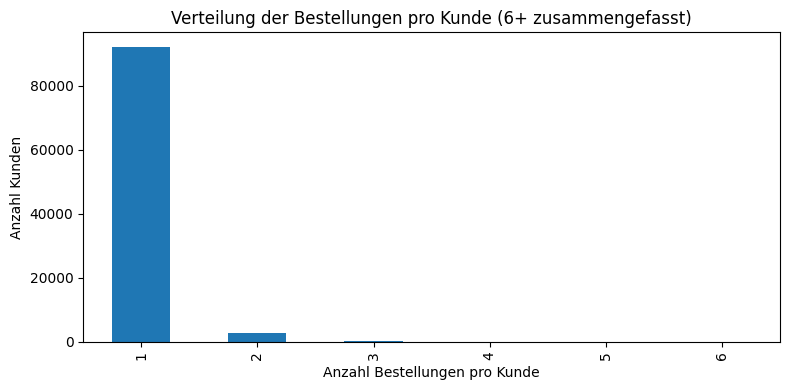

In [62]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# --- Setup / Laden ---
BASE = Path.cwd().parent
PROC = BASE / "data" / "processed"
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

fact = pd.read_parquet(PROC / "fact_order_items.parquet")

# Falls customer_unique_id fehlt: aus customers mergen
if "customer_unique_id" not in fact.columns:
    customers = pd.read_csv(
        RAW / "olist_customers_dataset.csv",
        usecols=["customer_id","customer_unique_id"]
    )
    fact = fact.merge(customers, on="customer_id", how="left")

# Sanity-Check
assert "customer_unique_id" in fact.columns, "customer_unique_id fehlt weiterhin."
assert "order_id" in fact.columns, "order_id fehlt in fact."

# --- Wiederbesteller-Analyse ---
orders_per_customer = (
    fact.groupby("customer_unique_id")["order_id"]
        .nunique()                            # zählt eindeutige Bestellungen pro Kunde
        .rename("order_count")
)

total_customers  = len(orders_per_customer)
repeat_customers = int((orders_per_customer > 1).sum())
repeat_share     = repeat_customers / total_customers * 100
avg_orders       = float(orders_per_customer.mean())

print(f"Gesamtzahl Kunden: {total_customers:,}")
print(f"Wiederbesteller (>1 Bestellung): {repeat_customers:,}")
print(f"Anteil Wiederbesteller: {repeat_share:.2f}%")
print(f"Durchschnittliche Bestellungen/Kunde: {avg_orders:.2f}")

# --- Verteilung visualisieren ---
plt.figure(figsize=(8,4))
(orders_per_customer.clip(upper=6)          # ab 6+ zusammenfassen
                    .value_counts()
                    .sort_index()
                    .plot(kind="bar"))
plt.title("Verteilung der Bestellungen pro Kunde (6+ zusammengefasst)")
plt.xlabel("Anzahl Bestellungen pro Kunde")
plt.ylabel("Anzahl Kunden")
plt.tight_layout()
plt.show()


,anzahl_kunden,anzahl_bestellungen,avg_bestellungen_pro_kunde,avg_warenkorbwert,avg_versandkosten,avg_lieferzeit,avg_review_score
customer_type,,,,,,,
Einmalkäufer,92096,92096,1.00,138.38,22.82,12.11,4.11
Wiederkäufer,2887,6103,2.24,122.97,22.90,11.87,4.18


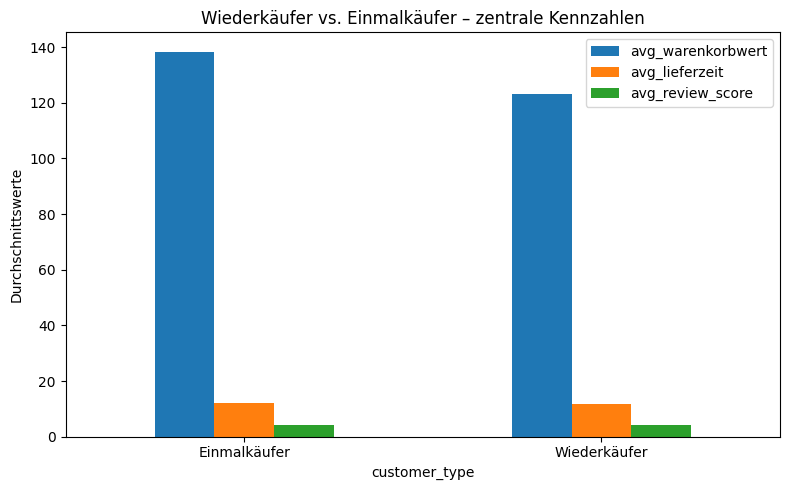

In [63]:
# --- Robust: orders-Level für Kundenvergleich bauen ---

import pandas as pd
from pathlib import Path

BASE = Path.cwd().parent
PROC = BASE / "data" / "processed"
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

# 1) Basis: unique (order_id, customer_unique_id)
fact = pd.read_parquet(PROC / "fact_order_items.parquet")
if "customer_unique_id" not in fact.columns:
    customers = pd.read_csv(RAW / "olist_customers_dataset.csv",
                            usecols=["customer_id","customer_unique_id"])
    fact = fact.merge(customers, on="customer_id", how="left")

orders_lvl = fact[["order_id","customer_unique_id"]].drop_duplicates()

# 2) Preis & Fracht (ggf. aus raw order_items aggregieren)
if not {"price","freight_value"}.issubset(fact.columns):
    oi = pd.read_csv(RAW / "olist_order_items_dataset.csv",
                     usecols=["order_id","price","freight_value"])
    vals = oi.groupby("order_id", as_index=False)[["price","freight_value"]].sum()
else:
    vals = (fact.groupby("order_id", as_index=False)[["price","freight_value"]].sum())
orders_lvl = orders_lvl.merge(vals, on="order_id", how="left")

# 3) Lieferdauer (aus orders berechnen)
orders = pd.read_csv(RAW / "olist_orders_dataset.csv",
                     usecols=["order_id","order_status",
                              "order_purchase_timestamp","order_delivered_customer_date"],
                     parse_dates=["order_purchase_timestamp","order_delivered_customer_date"])
orders_valid = orders[orders["order_status"]=="delivered"].copy()
orders_valid["delivery_days"] = (
    orders_valid["order_delivered_customer_date"] - orders_valid["order_purchase_timestamp"]
).dt.days
orders_lvl = orders_lvl.merge(orders_valid[["order_id","delivery_days"]], on="order_id", how="left")

# 4) Review-Score (Bestell-ebene mitteln)
reviews = pd.read_csv(RAW / "olist_order_reviews_dataset.csv",
                      usecols=["order_id","review_score"])
rev = reviews.groupby("order_id", as_index=False)["review_score"].mean()
orders_lvl = orders_lvl.merge(rev, on="order_id", how="left")

# 5) Käufertyp (Einmal vs. Wieder)
cust_counts = (
    orders_lvl.groupby("customer_unique_id")["order_id"].nunique().rename("order_count")
)
orders_lvl = orders_lvl.merge(cust_counts, on="customer_unique_id", how="left")
orders_lvl["customer_type"] = orders_lvl["order_count"].apply(
    lambda x: "Wiederkäufer" if x > 1 else "Einmalkäufer"
)

# --- Kennzahlen-Tabellen & Plot ---
summary = (
    orders_lvl.groupby("customer_type")
    .agg(
        anzahl_kunden=("customer_unique_id","nunique"),
        anzahl_bestellungen=("order_id","nunique"),
        avg_bestellungen_pro_kunde=("order_count","mean"),
        avg_warenkorbwert=("price","mean"),
        avg_versandkosten=("freight_value","mean"),
        avg_lieferzeit=("delivery_days","mean"),
        avg_review_score=("review_score","mean"),
    )
    .round(2)
)

display(summary)

import matplotlib.pyplot as plt
summary[["avg_warenkorbwert","avg_lieferzeit","avg_review_score"]].plot(
    kind="bar", figsize=(8,5)
)
plt.title("Wiederkäufer vs. Einmalkäufer – zentrale Kennzahlen")
plt.ylabel("Durchschnittswerte")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- Umsatzspalte finden/erzeugen ---
revenue_col = None

if "item_revenue_brl" in fact.columns:
    revenue_col = "item_revenue_brl"

elif "price" in fact.columns:
    revenue_col = "price"

else:
    # aus RAW order_items aggregieren und in fact mergen
    BASE = Path.cwd().parent         # wenn Notebook in /notebooks liegt
    RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

    oi = pd.read_csv(RAW / "olist_order_items_dataset.csv",
                     usecols=["order_id","price","freight_value"])
    oi["item_revenue_brl"] = oi["price"].fillna(0) + oi["freight_value"].fillna(0)
    order_value = oi.groupby("order_id", as_index=False)["item_revenue_brl"].sum()

    if "order_id" not in fact.columns:
        raise KeyError("In 'fact' fehlt 'order_id' – ohne das können wir nicht mergen.")

    fact = fact.merge(order_value, on="order_id", how="left")  # fügt item_revenue_brl hinzu
    revenue_col = "item_revenue_brl"

print("Umsatzspalte:", revenue_col)


Umsatzspalte: item_revenue_brl


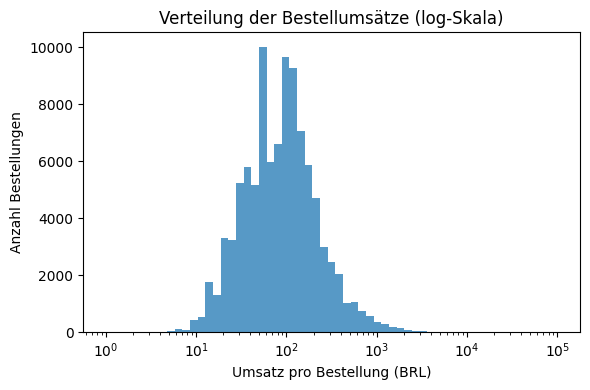

In [65]:
order_values = (
    fact.groupby("order_id")[revenue_col]
        .sum()
        .reset_index(name="order_value_brl")
)

plt.figure(figsize=(6,4))
sns.histplot(order_values["order_value_brl"].dropna(), bins=np.logspace(0, 5, 60))
plt.xscale("log")
plt.title("Verteilung der Bestellumsätze (log-Skala)")
plt.xlabel("Umsatz pro Bestellung (BRL)")
plt.ylabel("Anzahl Bestellungen")
plt.tight_layout(); plt.show()
